In [1]:
# Loading packages
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the dataset
loan_df = pd.read_csv('../raw_data/loan_data_2007_2014.csv')
df_backup = loan_df.copy()
loan_df.info()

/tmp/ipykernel_8597/2729177796.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_df = pd.read_csv('../raw_data/loan_data_2007_2014.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

# Target feature:
'loan_status' is the column that tells you wether there's been a default

In [3]:
loan_df['loan_status'].unique()
loan_df['loan_status'].isnull().sum()

0

In [4]:
# Encoding classes on 'loan_status'
loan_df['default_target'] = np.where(loan_df['loan_status'] == 'Default', 1,
                            np.where(loan_df['loan_status'] == 'Charged Off' , 1,
                            np.where(loan_df['loan_status'] == 'In Grace Period', 1,
                            np.where(loan_df['loan_status'] == 'Late (31-120) days', 1,
                            np.where(loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off', 1,
                            np.where(loan_df['loan_status'] == 'Current', 0,
                            np.where(loan_df['loan_status'] == 'Fully Paid', 0,
                            np.where(loan_df['loan_status'] == 'Late (16-30) days', 0,
                            np.where(loan_df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid', 0, 0)))))))))

loan_df['default_target'].unique()

array([0, 1])

In [5]:
loan_df[['loan_amnt', 'home_ownership', 'loan_status', 'default_target']].head(10)

,loan_amnt,home_ownership,loan_status,default_target
0,5000,RENT,Fully Paid,0
1,2500,RENT,Charged Off,1
2,2400,RENT,Fully Paid,0
3,10000,RENT,Fully Paid,0
4,3000,RENT,Current,0
5,5000,RENT,Fully Paid,0
6,7000,RENT,Current,0
7,3000,RENT,Fully Paid,0
8,5600,OWN,Charged Off,1
9,5375,RENT,Charged Off,1


# Dataset exploration and feature selection

In [6]:
# Checking features
loan_df[loan_df['total_rev_hi_lim'] > 0]['total_rev_hi_lim'].sort_values(ascending = False)

301370    9999999.0
129958    9999999.0
178261    2013133.0
60570     1998700.0
232762    1508600.0
            ...    
404086        100.0
190846        100.0
319257        100.0
444579        100.0
80560         100.0
Name: total_rev_hi_lim, Length: 395854, dtype: float64

In [7]:
# Too many columns with a lot of NAs

# Discuss with team ----
# tot_cur_bal                     70276
# tot_coll_amt                    70276

loan_df.isnull().sum().sort_values(ascending = False)

open_acc_6m                  466285
il_util                      466285
verification_status_joint    466285
dti_joint                    466285
annual_inc_joint             466285
                              ...  
total_pymnt                       0
total_pymnt_inv                   0
total_rec_prncp                   0
total_rec_int                     0
default_target                    0
Length: 76, dtype: int64

In [8]:
# Selecting only the features that might be the most important
X = loan_df[[
    'default_target'
    , 'loan_amnt' #STD
    , 'funded_amnt' #STD
    , 'funded_amnt_inv' #STD
    , 'term' # 36 or 60 -> OHE
    , 'int_rate' # STD
    , 'installment' # STD
    , 'grade' # Transform grade + subgrade into one feature, then Encode
    , 'sub_grade' # OHE
    # , 'emp_title' # Too chaotic. Drop
    , 'emp_length' # STD
    , 'home_ownership' # OHE
    , 'annual_inc' # STD
    , 'verification_status' # OHE
    , 'dti' # STD
    , 'delinq_2yrs' # STD
    , 'pub_rec' # STD
    , 'revol_bal' # STD
    , 'revol_util' # STD
    , 'total_acc' # STD
    , 'out_prncp' # Transform into % of loan_amnt - "Remaining outsdanding principal for total amount funded"
    , 'total_pymnt' # CHANGE to % of total payment
    , 'total_rec_prncp' # CHANGE to % of loan paid to date
    , 'total_rec_late_fee' # CHANGE to % of total fees that were late
    , 'last_pymnt_d' # CHANGE to days since last payment: if > 30 = late
    # , 'next_pymnt_d' # Too many NAs Do something with 'last_pymnt_d'? 
    , 'last_pymnt_amnt' # CHANGE to amount received - installment price
    # , 'mths_since_last_major_derog' # Too many NAs
    , 'application_type'
    # , 'annual_inc_joint' # all NA
    # , 'dti_joint' # all NA
    # , 'verification_status_joint' # all NA
    , 'acc_now_delinq' # STD
    , 'tot_coll_amt' # STD
    , 'tot_cur_bal' # loan_amt/tot_cur_bal -> payment capacity
    # , 'total_rev_hi_lim' # Too chaotic. Better drop?
]]

# X.head(10)

In [9]:
X['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

KeyboardInterrupt: 

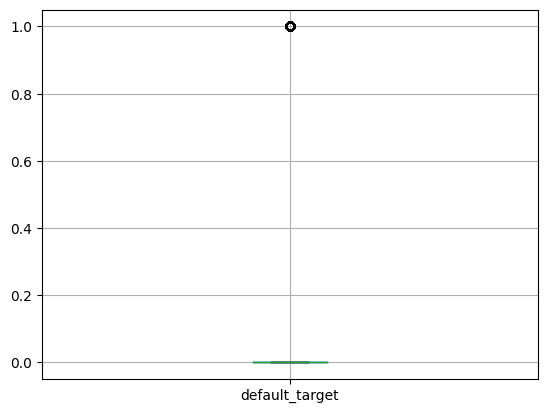

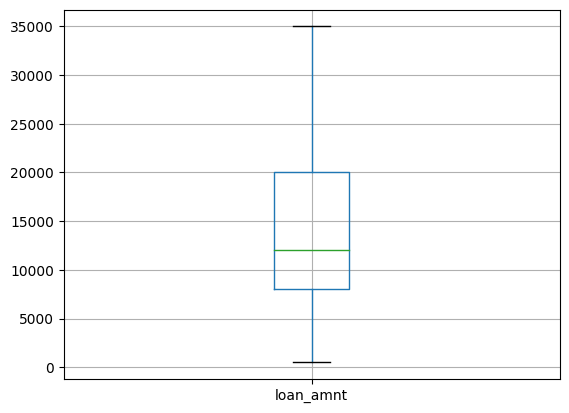

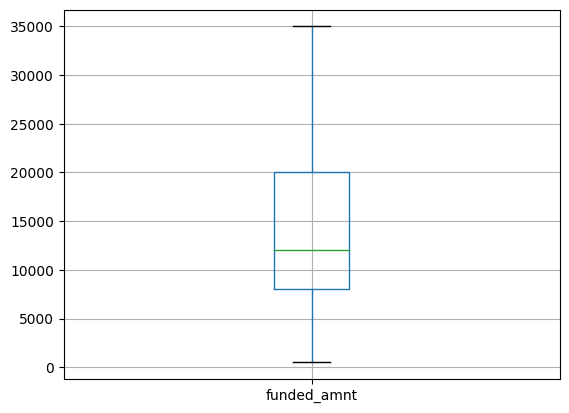

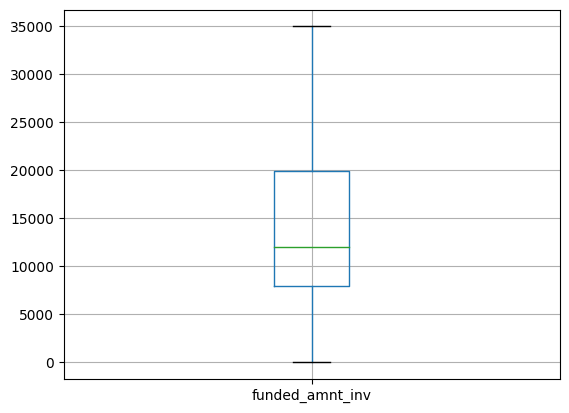

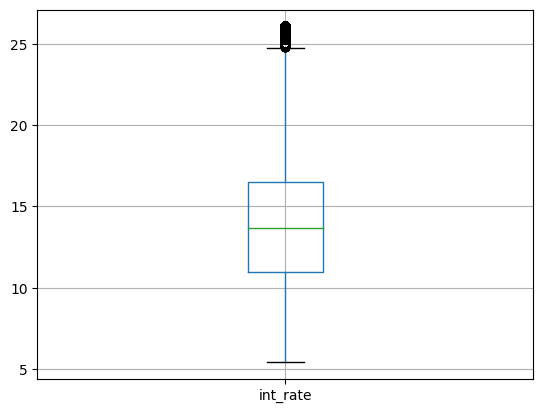

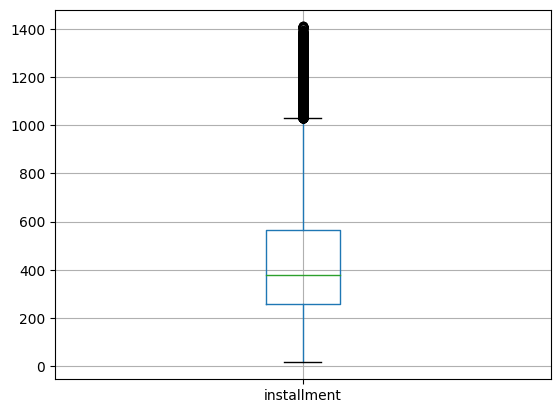

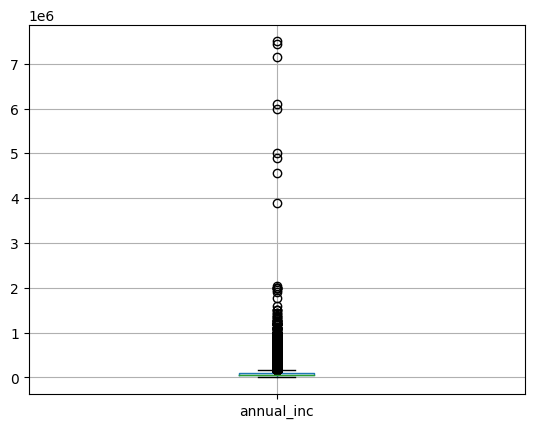

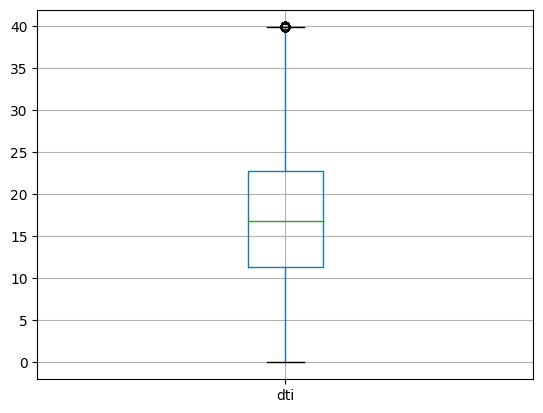

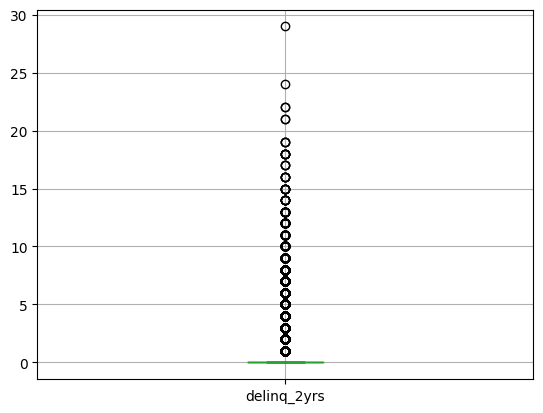

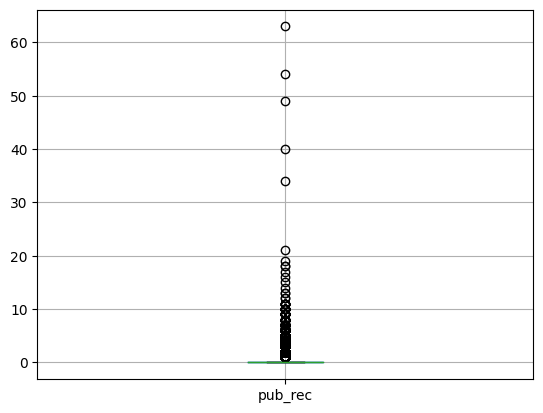

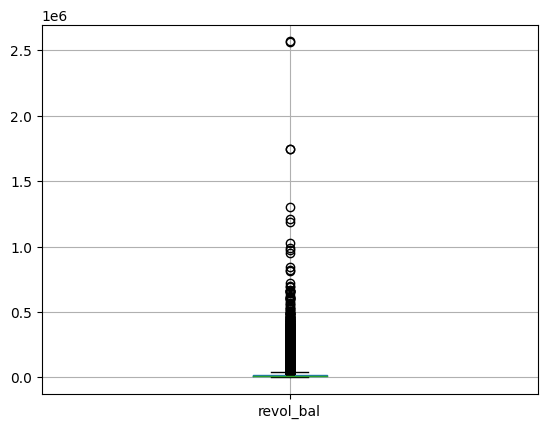

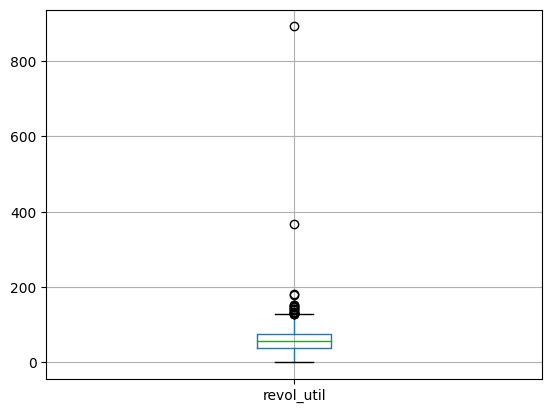

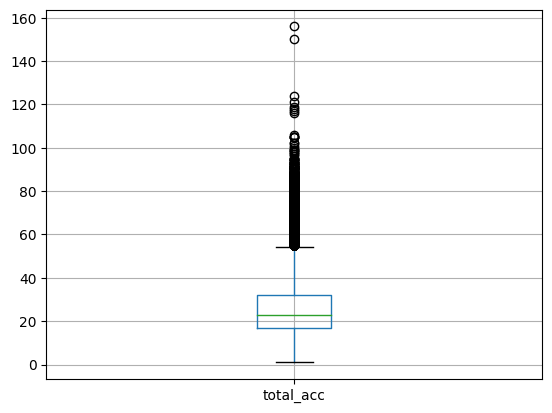

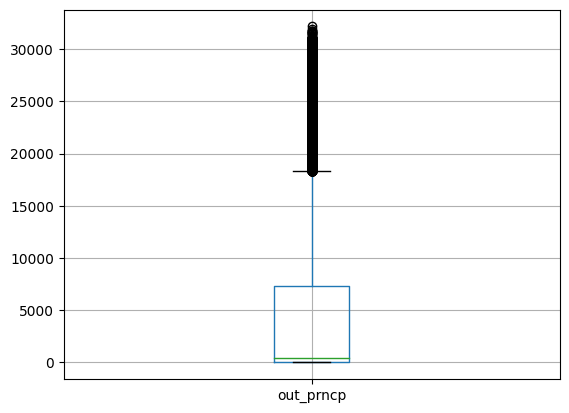

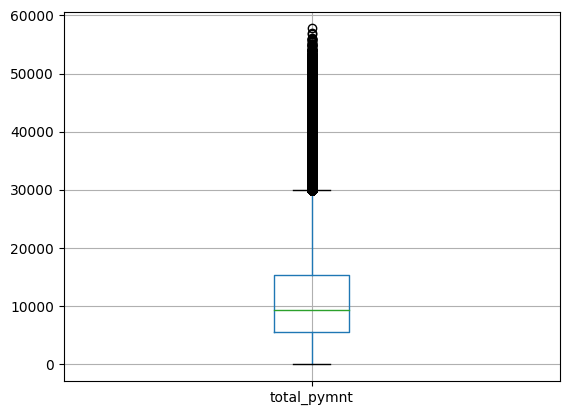

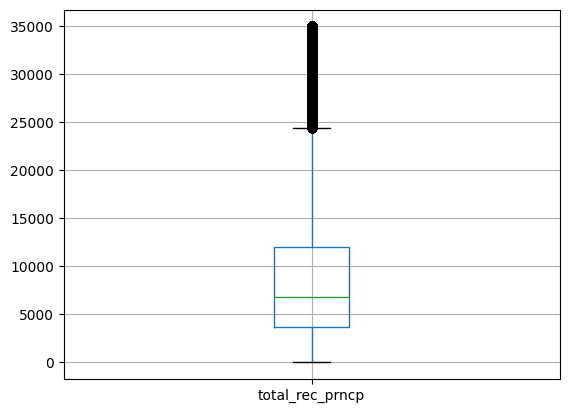

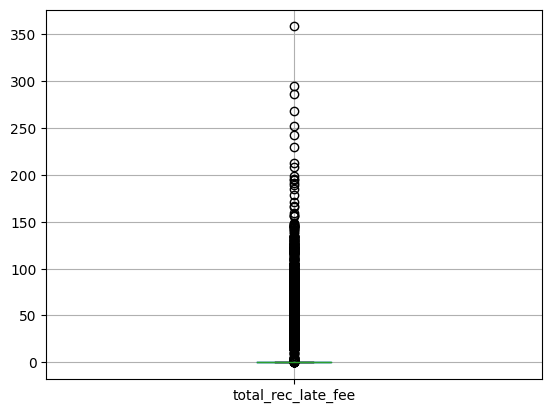

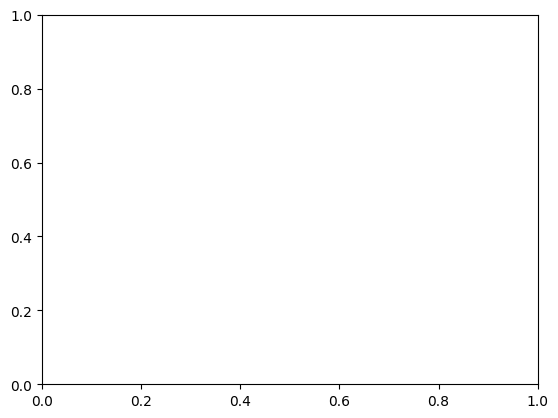

In [10]:
for column in X:
    if is_numeric_dtype(X[column]):
        plt.figure()
        X.boxplot([column])

# Encoding features

In [ ]:
#### Treating features
# Importing packages
from sklearn.preprocessing import StandardScaler

# Standardizing continuous features

standardizer = StandardScaler()

X['loan_amnt'], X['funded_amnt'], X['funded_amnt_inv'], X['int_rate'], X['installment'], X['annual_inc'] =  standardizer.fit_transform(X[['loan_amnt','funded_amnt','funded_amnt_inv', 'int_rate', 'installment', 'annual_inc']]).T

X.head()
# OHE categorical features

/tmp/ipykernel_10875/1008017838.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['loan_amnt'], X['funded_amnt'], X['funded_amnt_inv'], X['int_rate'], X['installment'], X['annual_inc'] =  standardizer.fit_transform(X[['loan_amnt','funded_amnt','funded_amnt_inv', 'int_rate', 'installment', 'annual_inc']]).T


,default_target,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,out_prncp,total_pymnt,total_rec_prncp,total_rec_late_fee,last_pymnt_d,last_pymnt_amnt,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal
0,0,-1.124392,-1.122963,-1.114455,36 months,-0.729587,-1.105575,B,B2,10+ years,...,0.0,5861.071414,5000.00,0.00,Jan-15,171.62,INDIVIDUAL,0.0,NaN,NaN
1,1,-1.426088,-1.425101,-1.412732,60 months,0.330634,-1.528763,C,C4,< 1 year,...,0.0,1008.710000,456.46,0.00,Apr-13,119.66,INDIVIDUAL,0.0,NaN,NaN
2,0,-1.438156,-1.437186,-1.424784,36 months,0.488979,-1.428140,C,C5,10+ years,...,0.0,3003.653644,2400.00,0.00,Jun-14,649.91,INDIVIDUAL,0.0,NaN,NaN
3,0,-0.521001,-0.518687,-0.508860,36 months,-0.077850,-0.380931,C,C1,10+ years,...,0.0,12226.302210,10000.00,16.97,Jan-15,357.48,INDIVIDUAL,0.0,NaN,NaN
4,0,-1.365749,-1.364673,-1.352474,60 months,-0.261438,-1.496071,B,B5,1 year,...,766.9,3242.170000,2233.10,0.00,Jan-16,67.79,INDIVIDUAL,0.0,NaN,NaN


# Logit for Default probability

In [11]:
import statsmodels.formula.api as smf

In [12]:
# Instatiating the model
from sklearn.linear_model import LogisticRegression

model = smf.logit(formula='''
                  default_target ~ loan_amnt + funded_amnt + funded_amnt_inv + C(term)
                  + int_rate + installment + C(grade) + C(emp_length) + C(home_ownership)
                  + annual_inc + C(verification_status)
                  '''
                  , data=loan_df).fit(maxiter = 500)

# Features not used
# + dti + delinq_2yrs + pub_rec
# + revol_bal + revol_util + total_acc + out_prncp + total_pymnt 
# + total_rec_prncp + total_rec_late_fee + last_pymnt_amnt
# + C(application_type) + acc_now_delinq + tot_coll_amt + tot_cur_bal

         Current function value: 0.308742
         Iterations: 500


/home/joao/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Results and coefficients
model.params

Intercept                                   -38.346475
C(term)[T. 60 months]                         0.275442
C(sub_grade)[T.A2]                            0.326127
C(sub_grade)[T.A3]                            0.353563
C(sub_grade)[T.A4]                            0.550179
C(sub_grade)[T.A5]                            0.542969
C(sub_grade)[T.B1]                            0.557644
C(sub_grade)[T.B2]                            0.548198
C(sub_grade)[T.B3]                            0.561744
C(sub_grade)[T.B4]                            0.531187
C(sub_grade)[T.B5]                            0.523534
C(sub_grade)[T.C1]                            0.515680
C(sub_grade)[T.C2]                            0.476902
C(sub_grade)[T.C3]                            0.510432
C(sub_grade)[T.C4]                            0.471440
C(sub_grade)[T.C5]                            0.440286
C(sub_grade)[T.D1]                            0.405538
C(sub_grade)[T.D2]                            0.419631
C(sub_grad

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         default_target   No. Observations:               445273
Model:                          Logit   Df Residuals:                   445242
Method:                           MLE   Df Model:                           30
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.05314
Time:                        20:19:56   Log-Likelihood:            -1.3747e+05
converged:                      False   LL-Null:                   -1.4519e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                   -23.4481   6.74e+04     -0.000      1.000   -1.32e+05    1.32e+05
C(term)[T. 60 months]                         0.2692      0.029      9.361      0.000       0.213       0.326
C(grade)[T.B]                                 0.1262      0.028      4.520      0.000       0.071       0.181
C(grade)[T.C]                                 0.0858      0.036      2.387      0.017       0.015       0.156
C(grade)[T.D]                                 0.0019      0.046      0.042      0.967      -0.088       0.092
C(grade)[T.E]                                -0.1355      0.057     -2.372      0.018      -0.248      -0.024
C(grade)[T.F]                                -0.3146      0.070     -4.492      0.000      -0.452      -0.177
C(grade)[T.G]                                -0.3206      0.083     -3.879      0.000      -0.483      -0.159
C(emp_length)[T.10+ years]                   -0.0982      0.022     -4.526      0.000      -0.141      -0.056
C(emp_length)[T.2 years]                     -0.0065      0.026     -0.254      0.800      -0.056       0.044
C(emp_length)[T.3 years]                      0.0078      0.026      0.299      0.765      -0.043       0.059
C(emp_length)[T.4 years]                     -0.0051      0.028     -0.184      0.854      -0.060       0.050
C(emp_length)[T.5 years]                      0.0584      0.027      2.162      0.031       0.005       0.111
C(emp_length)[T.6 years]                      0.0677      0.028      2.412      0.016       0.013       0.123
C(emp_length)[T.7 years]                      0.0102      0.028      0.359      0.720      -0.045       0.066
C(emp_length)[T.8 years]                      0.0016      0.030      0.052      0.958      -0.057       0.060
C(emp_length)[T.9 years]                      0.0146      0.032      0.459      0.646      -0.048       0.077
C(emp_length)[T.< 1 year]                     0.0662      0.026      2.555      0.011       0.015       0.117
C(home_ownership)[T.MORTGAGE]                19.3968   6.74e+04      0.000      1.000   -1.32e+05    1.32e+05
C(home_ownership)[T.NONE]                    19.7023   6.74e+04      0.000      1.000   -1.32e+05    1.32e+05
C(home_ownership)[T.OTHER]                   20.0641   6.74e+04      0.000      1.000   -1.32e+05    1.32e+05
C(home_ownership)[T.OWN]                     19.4207   6.74e+04      0.000      1.000   -1.32e+05    1.32e+05
C(home_ownership)[T.RENT]                    19.5493   6.74e+04      0.000      1.000   -1.32e+05    1.32e+05
C(verification_status)[T.Source Verified]    -0.0679      0.014     -4.870      0.000      -0.095      -0.041
C(verification_status)[T.Verified]            0.0946      0.014      6.804      0.000       0.067       0.122
loan_amnt                                     0.0001   8.46e-06     11.992      0.000    8.48e-05       0.000
funded_amnt                               -1.065e-0

In [ ]:
# Validating the model


# Estimating Interest Rates via Linear Regression

# Neural Network to determine Default